# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Visualizations will be shown in the notebook.
%matplotlib inline
from tensorflow.contrib.layers import flatten
from sklearn import preprocessing
from tensorflow.contrib.layers import flatten
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
import os
from scipy.misc import imresize
from scipy.misc import imread
from PIL import Image
from numpy import linalg as LA
import cv2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from skimage.exposure import equalize_adapthist as clahe

Using TensorFlow backend.


In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape

# TODO: Number of testing examples.
n_test = X_test.shape

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train[-1] + 1

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape            =", image_shape)
print("Number of classes           =", n_classes)

Number of training examples = (39209, 32, 32, 3)
Number of testing examples  = (12630, 32, 32, 3)
Image data shape            = (32, 32, 3)
Number of classes           = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

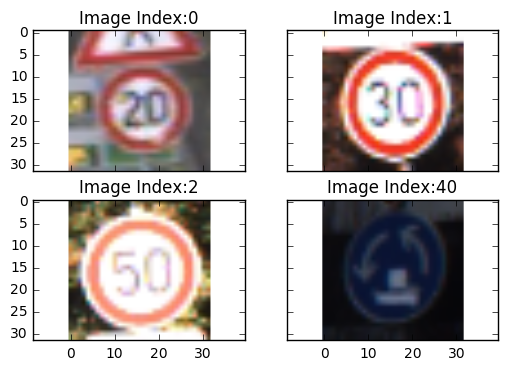

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax1.imshow(X_train[4,:,:,:])
ax1.set_title("Image Index:" + str(y_train[4]))

ax2.imshow(X_train[400,:,:,:])
ax2.set_title("Image Index:" + str(y_train[400]))

ax3.imshow(X_train[4000,:,:,:])
ax3.set_title("Image Index:" + str(y_train[4000]))

ax4.imshow(X_train[38500,:,:,:])
ax4.set_title("Image Index:" + str(y_train[38500]))


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [7]:
# This is for randomizing the data
def randomize(n_train, dataset, labels):
    shuffled_dataset = np.zeros((n_train,32,32,3), dtype=np.float32)
    shuffled_labels  = np.zeros((n_train), dtype=np.float32)
    
    permutation = np.random.permutation(labels.shape[0])
    
    for i in range(n_train):
        shuffled_dataset[i,:,:,:] = dataset[permutation[i],:,:,:]
        shuffled_labels[i]    = labels[permutation[i]]
        
    return shuffled_dataset, shuffled_labels

In [8]:
random_dataset, random_labels = randomize(n_train[0],X_train, y_train)
print('Train Dataset: ', random_dataset.shape)
print('Train Labels : ', random_labels.shape)

Train Dataset:  (39209, 32, 32, 3)
Train Labels :  (39209,)


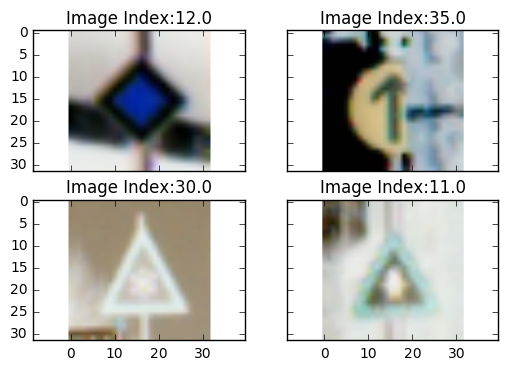

In [9]:
#Visualize the randomized dataset for verification:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax1.imshow(random_dataset[4,:,:,:])
ax1.set_title("Image Index:" + str(random_labels[4]))

ax2.imshow(random_dataset[400,:,:,:])
ax2.set_title("Image Index:" + str(random_labels[400]))

ax3.imshow(random_dataset[4000,:,:,:])
ax3.set_title("Image Index:" + str(random_labels[4000]))

ax4.imshow(random_dataset[39000,:,:,:])
ax4.set_title("Image Index:" + str(random_labels[39000]))

In [10]:
# One-Hot enconding
def one_hot(y, n_classes):
    labels = (np.arange(n_classes) == y[:,None]).astype(np.float32)    
    return labels

In [11]:
ytrain = one_hot(random_labels, n_classes)
ytest  = one_hot(y_test, n_classes)

print('Train Label Shape:', ytrain.shape)
print('Test Label Shape:', ytest.shape)

# Check the validity of one-hot encoding
print('Train Label')
print(random_labels[4])
print(ytrain[4])
print('***********')
print(random_labels[39208])
print(ytrain[39208])
print('Test Label')
print(y_test[0])
print(ytest[0])
print('***********')
print(y_test[100])
print(ytest[100])

Train Label Shape: (39209, 43)
Test Label Shape: (12630, 43)
Train Label
12.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
***********
14.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
Test Label
16
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
***********
1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [12]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [13]:
def data_augement(dataX, dataY):
    
    dataX_return = np.zeros((dataX.shape[0], 32,32,3))
    dataY_return = np.zeros((dataY.shape[0]))
    
    datagen = ImageDataGenerator(rotation_range=0,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=False,
                                fill_mode='nearest')
    
    for i in range(dataX.shape[0]):
        
        x = img_to_array(dataX[i,:,:,:])
        x = x.reshape((1,) + x.shape)
        
        dataY_return[i] = dataY[i]
        
        for batch in datagen.flow(x, batch_size = 1):
            dataX_return[i,:,:,:] = batch
            break
            
    # Concatenate the original data with augmented data
    datax = np.concatenate((dataX, dataX_return), axis = 0)
    datay = np.concatenate((dataY, dataY_return), axis = 0)
    
    return datax, datay


In [14]:
def normalize_data(data):
    
    if data.shape[3] == 1:
        num_data = data.shape[0]
        norm_data = np.zeros((num_data,32,32,1), dtype=np.float32)
        
        for i in range(num_data):
            grey = data[i,:,:,:]
            grey = np.reshape(grey, (32,32))
            grey = grey/255.0
            norm_image = clahe(grey, kernel_size=None, clip_limit=0.01, nbins=256)
            norm_image = np.reshape(norm_image, (32,32,1))
            norm_data[i,:,:,:] = norm_image
    else:
        num_data = data.shape[0]
        norm_data = np.zeros((num_data,32,32,3), dtype=np.float32)
                
        for i in range(num_data):
            rgb = data[i,:,:,:]/255.0
            norm_data[i,:,:,:] = clahe(rgb, kernel_size=None, clip_limit=0.01, nbins=256)
    
    return norm_data

In [15]:
def greyscale(data):
    num_data = data.shape[0]
    grey_data = np.zeros((num_data,32,32,1), dtype=np.float32)
    
    for i in range(num_data):
        img = cv2.cvtColor(data[i,:,:,:], cv2.COLOR_RGB2GRAY)
        grey_data[i,:,:,:] = np.reshape(img, (32,32,1))
    
    return grey_data

In [16]:
# Split the traning dataset into Validation dataset(approx. 1% of training data) and Training dataset.
train_dataset, val_dataset, train_labels, val_labels = train_test_split(random_dataset, random_labels, test_size=0.01, random_state=0)

#Generate data additional data using training dataset
x, y = data_augement(train_dataset, train_labels)

augmented_train_data   = np.array(x)
augmented_train_labels = np.array(y)

# Randomize the augmented dataset
random_augmented_dataset, random_augmented_labels = randomize(augmented_train_data.shape[0], augmented_train_data, augmented_train_labels)

# Even more data from original:
x1, y1 = data_augement(train_dataset, train_labels)

more_augmented_train_data   = np.array(x1)
more_augmented_train_labels = np.array(y1)

more_augmented_train_data = np.concatenate((more_augmented_train_data, random_augmented_dataset), axis = 0)
more_augmented_train_labels = np.concatenate((more_augmented_train_labels, random_augmented_labels), axis = 0)

In [17]:
#Randomize the More augmented dataset
more_random_augmented_dataset, more_random_augmented_labels = randomize(more_augmented_train_data.shape[0], more_augmented_train_data, more_augmented_train_labels)

In [18]:
# Convert to grey-dataset
grey_more_random_augmented_dataset = greyscale(more_random_augmented_dataset)
print('grey-scale ', grey_more_random_augmented_dataset.shape)

grey-scale  (155264, 32, 32, 1)


In [19]:
# convert to greyscale for val and test set
grey_test = greyscale(X_test)
grey_val  = greyscale(val_dataset)
grey_random_augmented_dataset = greyscale(random_augmented_dataset)

print('grey_test:', grey_test.shape)
print('grey_val :', grey_val.shape)
print('gey_random_augmented_dataset :', grey_random_augmented_dataset.shape)

grey_test: (12630, 32, 32, 1)
grey_val : (393, 32, 32, 1)
gey_random_augmented_dataset : (77632, 32, 32, 1)


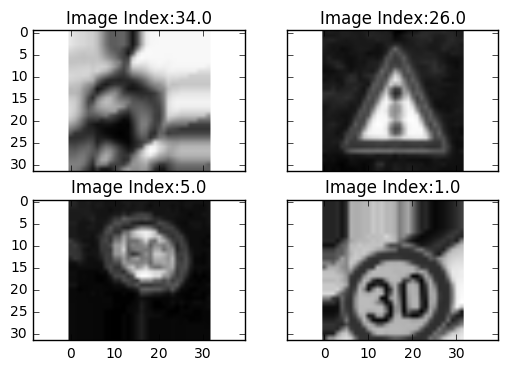

In [20]:
im1 = grey_more_random_augmented_dataset[0,:,:,:]
im2 = grey_more_random_augmented_dataset[39209,:,:,:]
im3 = grey_more_random_augmented_dataset[39208,:,:,:]
im4 = grey_more_random_augmented_dataset[47061,:,:,:]

im1 = np.reshape(im1, (32,32))
im2 = np.reshape(im2, (32,32))
im3 = np.reshape(im3, (32,32))
im4 = np.reshape(im4, (32,32))

#Visualize the grey augmented ramdomized dataset for verification:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax1.imshow(im1, cmap = 'gray')
ax1.set_title("Image Index:" + str(more_random_augmented_labels[0]))

ax2.imshow(im2, cmap = 'gray')
ax2.set_title("Image Index:" + str(more_random_augmented_labels[39209]))

ax3.imshow(im3, cmap = 'gray')
ax3.set_title("Image Index:" + str(more_random_augmented_labels[39208]))

ax4.imshow(im4, cmap = 'gray')
ax4.set_title("Image Index:" + str(more_random_augmented_labels[47061]))

In [21]:
# Convert the training labels into one-hot encoding:
y_train_labels = one_hot(train_labels, n_classes)

# Convert the augmented training labels into one-hot encoding:
y_random_augmented_labels = one_hot(random_augmented_labels, n_classes)

# Convert the validation labels into one-hot encoding:
y_val_labels = one_hot(val_labels, n_classes)

# Convert the more augmented training labels into one-hot encoding:
y_more_random_augmented_labels = one_hot(more_random_augmented_labels, n_classes)

# Normalize dataset
#norm_X_test = normalize_data(X_test)
norm_grey_test = normalize_data(grey_test)
#norm_val_dataset   = normalize_data(val_dataset)
#norm_train_dataset = normalize_data(train_dataset)
norm_grey_val_dataset = normalize_data(grey_val)
#norm_random_augmented_dataset = normalize_data(random_augmented_dataset)
#norm_grey_random_augmented_dataset = normalize_data(grey_random_augmented_dataset)
norm_more_random_augmented_dataset = normalize_data(more_random_augmented_dataset)
norm_grey_more_random_augmented_dataset = normalize_data(grey_more_random_augmented_dataset)

#print('Orginal Train Data  : ', norm_train_dataset.shape)
#print('Orginal Train Labels: ', y_train_labels.shape)

#print('Randomized Generated Train Data  : ', norm_random_augmented_dataset.shape)
#print('Randomized Generated Train Labels: ', y_random_augmented_labels.shape)

#print('Grey Randomized Generated Train Data  : ',norm_grey_random_augmented_dataset.shape)
#print('Grey Randomized Generated Train Labels: ', y_random_augmented_labels.shape)

#print("Number of validation dataset =", norm_val_dataset.shape)
#print("Number of validation label   =", y_val_labels.shape)

print('More Randomized Generated Train Data  : ', norm_more_random_augmented_dataset.shape)
print('More Randomized Generated Train Labels: ', y_more_random_augmented_labels.shape)

print('Grey More Randomized Generated Train Data  : ', norm_grey_more_random_augmented_dataset.shape)
print('Grey More Randomized Generated Train Labels: ', y_more_random_augmented_labels.shape)

More Randomized Generated Train Data  :  (155264, 32, 32, 3)
More Randomized Generated Train Labels:  (155264, 43)
Grey More Randomized Generated Train Data  :  (155264, 32, 32, 1)
Grey More Randomized Generated Train Labels:  (155264, 43)


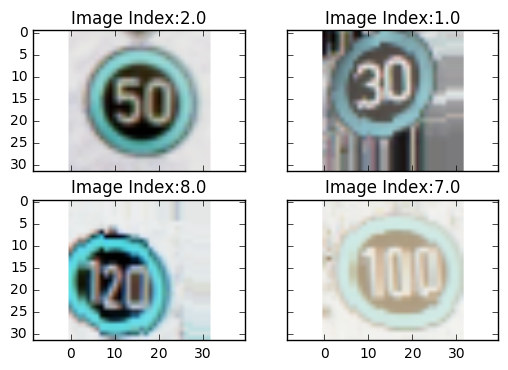

In [22]:
#Visualize the augmented ramdomized dataset for verification:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax1.imshow(augmented_train_data[0,:,:,:])
ax1.set_title("Image Index:" + str(augmented_train_labels[0]))

ax2.imshow(augmented_train_data[39209,:,:,:])
ax2.set_title("Image Index:" + str(augmented_train_labels[39209]))

ax3.imshow(augmented_train_data[39208,:,:,:])
ax3.set_title("Image Index:" + str(augmented_train_labels[39208]))

ax4.imshow(augmented_train_data[47061,:,:,:])
ax4.set_title("Image Index:" + str(augmented_train_labels[47061]))

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1. Before any pre-processing, I randomized the training dataset.

2. The training dataset, test dataset and validation datasets were all converted to greyscale. This helped to bring the testing accuracy from around 85% to 91%.

3. The training dataset, test dataset and validation datasets was normalized using to have unit norm. This was done using the sklearn package called normalizer. The regularization used was L2. Mean normalization was done in order for the function to minimize faster. Even with normalization, I was able to only achieve testing accuracy of 83%.

4. But After I used a different normalization technique called Contrast Limited Adaptive Histogram Equalization (CLAHE). This is an algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image. CLAHE normalization can help in case of High contrast variation among the images. This was done in order to achieve better results. After CLAHE normalization was done on the generated dataset, the training set accuracy when from around 83% to 91%.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Splited the randomized training dataset into validation and training sets, using the sklearn package train_test_split method.

2. Generated additional data in the training set. This was done by using the keras image pre-processing package. It augments the each image in the dataset randomly based on augmentation parameters like: horizontal flip, zoom, shift, etc. Performing translations, scalings and rotations of the training set considerably improved the generalization.

3. Joined both the original training data and generated training data to form a new training set.

4. The new training data was again randomized. All the Training, Validation, and Testing datasets were converted to grey-scale and normalized.

5. Finally converted all the labels (train, val, etc.) into one-hot encodings.

#### Validation Data: 
Number of validation dataset = (1961, 32, 32, 1) <br />
Number of validation label   = (1,961, 43)

#### Generated training data:
Randomized Augmented Train Data  :  (155264, 32, 32, 1) <br />
Randomized Augmented Train Labels:  (155264, 43)

#### Testing Data:
The testing data was already given to us. <br />
Testing dataset: (12630, 32, 32, 1)<br />
Testing labels : (12630, 43)

In [23]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Le-Net
![LeNet Architecture](lenet.png)
Source: Yan LeCun

In [24]:
#******************************************************************************
'''
le-net
'''
#******************************************************************************


def LeNet(x):
    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Probability to keep units
    #keep_prob = tf.placeholder(tf.float32) 
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    

    # Pooling. Input = 28x28x6. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


# Alex-Net
![LeNet Architecture](alexnet.png)
Source: Alex Krizhevsky

In [25]:
def alexnet(data, keep_prob):
    # Re-size image:
    data = tf.image.resize_bilinear(data, (227,227))

    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    '''
    Convolutiona1 Layer -- 1
    '''
    conv1_W = tf.Variable(tf.truncated_normal(shape=(11, 11, 1, 10),  mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(data, conv1_W, strides=[1, 4, 4, 1], padding='SAME') + conv1_b
    # Activation
    conv1   = tf.nn.relu(conv1)
    
    '''
    Max-Pooling-1
    '''
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    '''
    Convolutiona1 Layer -- 2
    '''
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 36),  mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(36))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    # Activation
    conv2   = tf.nn.relu(conv2)

    '''
    Max-Pooling-2
    '''
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

        
    '''
    Convolutiona1 Layer -- 3
    '''
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 36, 54),  mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(54))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    # Activation
    conv3   = tf.nn.relu(conv3)
    
    '''
    Convolutiona1 Layer -- 4
    '''
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 54, 54),  mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(54))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    # Activation
    conv4   = tf.nn.relu(conv4)


    '''
    Convolutiona1 Layer -- 5
    '''
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 54, 36),  mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(36))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    # Activation
    conv5   = tf.nn.relu(conv5)
    
    '''
    Convolutiona1 Layer -- 6
    '''
    conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 36, 36),  mean = mu, stddev = sigma))
    conv6_b = tf.Variable(tf.zeros(36))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b
    # Activation
    conv6   = tf.nn.relu(conv6)
 
    '''
    Max-Pooling-3
    '''
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Reshape the 3-D tensor into 1-D vector
    fc0 = flatten(conv6)
    
    
    '''
    Fully-Connected Layer -- 1
    '''
    # Matrix Multiply
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1296, 1296), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1296))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    '''
    Fully-Connected Layer -- 2
    '''
    # Matrix Multiply
    fc2_W = tf.Variable(tf.truncated_normal(shape=(1296, 1296), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(1296))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)

    '''
    Fully-Connected Layer -- 3 
    '''
    # Matrix Multiply
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1296, 512), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(512))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Dropout:
    fc3 = tf.nn.dropout(fc3, keep_prob)
    
    '''
    Fully-Connected Layer -- 4 (Final Layer)
    '''
    # Matrix Multiply
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

## I have tried two standard architectures: Le-Net and Alex-net

### LeNet-5

#### Input
The LeNet architecture accepts a 32x32x1 image as input.

#### Architecture
**Layer 1: Convolutional.** <br>
Kernel: 5x5x1x6 <br>
Stride: 1x1 <br>
The output shape: 28x28x6. <br>

**Activation.** 
ReLU activation.

**Pooling.** <br>
Kernel: 2x2 <br>
Stride: 2x2 <br>
The output shape: 14x14x6. <br>

**Layer 2: Convolutional.** <br>
Kernel: 5x5x6x16<br>
Stride: 1x1 <br>
The output shape: 10x10x16. <br>

**Activation.** <br>
ReLU activation.

**Pooling.** <br>
Kernel: 2x2 <br>
Stride: 2x2 <br>
The output shape: 5x5x16. <br>

**Flatten.** <br>
Flattens the output shape of the final pooling layer such that it's 1D instead of 3D. <br>
Output = 400

**Layer 1: Fully Connected.** <br>
Layer Operation = 1x400 x 400x120 <br>
Layer Output = 1x120 <br>

**Activation.** <br>
ReLU activation.

**Layer 2: Fully Connected.** <br>
Layer Operation = 1x84 x 84x84 <br>
Layer Output =  1x84

**Activation.** <br>
ReLU activation.

**Layer 3: Fully Connected (Logits).** <br>
Layer Operation = 1x84 x 84x43 <br>
Layer Output = 1x43.

#### Output
43 outputs


### ---------------------------------------------------------------------------------------------

### Modified Alex-Net
I also experimented with alex-net architecure and was not getting better results. Because I was not able to achieve good results. I tried and modified the layers and added some more layers to get better output.

#### Input
The architecture accepts a 32x32x1 image as input and re-scales it to 227x227x1.

#### Architecture
**Layer 1: Convolutional.** <br>
Kernel: 11x11x1x12<br>
Stride: 4x4 <br>
The output shape: 57x57x12. <br>

**Activation.**  <br>
ReLU activation.

**Pooling.** <br>
Kernel: 3x3 <br>
Stride: 2x2 <br>
The output shape: 28x28x12. <br>


**Layer 2: Convolutional.** <br>
Kernel: 5x5x12x36 <br>
Stride: 1x1 <br>
The output shape: 26x26x36. <br>

**Activation.** <br> 
ReLU activation.

**Pooling.**  <br>
Kernel: 3x3 <br>
Stride: 2x2 <br>
The output shape: 13x13x36. <br>


**Layer 3: Convolutional.** <br>
Kernel: 3x3x36x36 <br>
Stride: 1x1 <br>
The output shape: 13x13x36. <br>

**Activation.**  <br>
ReLU activation.


**Layer 4: Convolutional.** <br>
Kernel: 3x3x36x54 <br>
Stride: 1x1 <br>
The output shape: 13x13x54. <br>

**Activation.** <br>
ReLU activation.


**Layer 5: Convolutional.** <br>
Kernel: 3x3x54x54 <br>
Stride: 1x1 <br>
The output shape: 13x13x54. <br>

**Activation.** ReLU activation.

**Layer 6: Convolutional.** <br>
Kernel: 3x3x54x36 <br>
Stride: 1x1 <br>
The output shape: 13x13x36. <br>

**Activation.** <br>
ReLU activation.

**Pooling.** <br>
Kernel: 3x3 <br>
Stride: 2x2 <br>
The output shape: 6x6x36. <br>


**Flatten.** <br>
Flattens the output shape of the final pooling layer such that it's 1D instead of 3D. <br>
Output = 1296

**Layer 1: Fully Connected.** <br>
Layer Operation = 1x1296 x 1296x1296 <br>
Layer Output = 1296

**Activation.** <br>
ReLU activation.

**Layer 2: Fully Connected.** <br>
Layer Operation = 1x1296 x 1296x1296 <br>
Layer Output = 1x1296

**Activation.** <br>
ReLU activation.

**Layer 3: Fully Connected.** <br>
Layer Operation = 1x1296 x 1296x512 <br>
Layer Output = 1x512

**Activation.** <br>
ReLU activation.

** Dropout Layer ** <br>
Added a dropout layer during training to prevent over-fitting.

**Layer 4: Fully Connected (Logits).** <br>
Layer Operation = 1x512 x 512x43 <br>
Layer Output = 43

#### Output
43 outputs

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [26]:
# Input data:
num_labels   = 43
num_channels = 1
image_size   = 32
# Num_images
BATCH_SIZE   = 30

tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
tf_train_labels  = tf.placeholder(tf.int32, shape=(None, 43))
keep_prob = tf.placeholder(tf.float32)

## Training Pipeline

In [27]:
# Training computation.

#logits = alexnet(tf_train_dataset, keep_prob, phase_train)
#logits = alexnet(tf_train_dataset, is_training)
logits = alexnet(tf_train_dataset, keep_prob)
#logits = LeNet(tf_train_dataset)

# Loss function
loss   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

# Training.
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(loss)

In [28]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_train_labels, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        
        batch_x = X_data[offset:offset+BATCH_SIZE]
        batch_y = y_data[offset:offset+BATCH_SIZE]
        
        #accuracy = sess.run(accuracy_operation, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y, is_training: False})
        accuracy = sess.run(accuracy_operation, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y, keep_prob: 1.0})

        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

In [30]:
# Training

with tf.Session() as sess:
    
    # Intialize all variables
    sess.run(tf.global_variables_initializer())
    #num_examples = len(norm_random_augmented_dataset)
    #num_examples = len(train_dataset)
    
    num_examples = len(norm_grey_more_random_augmented_dataset)
    
    print("Training...")
    
    for offset in range(0, num_examples, BATCH_SIZE):
        
        end = offset + BATCH_SIZE
        
        batch_x =  norm_grey_more_random_augmented_dataset[offset:end]
        batch_y =  y_more_random_augmented_labels[offset:end]
        
        #batch_x = norm_random_augmented_dataset[offset:end]
        #batch_y = y_random_augmented_labels[offset:end]
        
        #sess.run(optimizer, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y, is_training:True})
        sess.run(optimizer, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y, keep_prob: 0.75})

        if(offset%6000) == 0:
            print('Training Step:', offset)
            validation_accuracy = evaluate(norm_grey_val_dataset , y_val_labels)
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            

    print('Training Complete')
    
    #saver.save(sess, 'lenet')
    saver.save(sess, 'alexnet')
    print("Model saved")

Training...
Training Step: 0
Validation Accuracy = 0.003
Training Step: 6000
Validation Accuracy = 0.267
Training Step: 12000
Validation Accuracy = 0.405
Training Step: 18000
Validation Accuracy = 0.532
Training Step: 24000
Validation Accuracy = 0.534
Training Step: 30000
Validation Accuracy = 0.598
Training Step: 36000
Validation Accuracy = 0.672
Training Step: 42000
Validation Accuracy = 0.710
Training Step: 48000
Validation Accuracy = 0.740
Training Step: 54000
Validation Accuracy = 0.774
Training Step: 60000
Validation Accuracy = 0.809
Training Step: 66000
Validation Accuracy = 0.807
Training Step: 72000
Validation Accuracy = 0.837
Training Step: 78000
Validation Accuracy = 0.868
Training Step: 84000
Validation Accuracy = 0.840
Training Step: 90000
Validation Accuracy = 0.885
Training Step: 96000
Validation Accuracy = 0.873
Training Step: 102000
Validation Accuracy = 0.888
Training Step: 108000
Validation Accuracy = 0.921
Training Step: 114000
Validation Accuracy = 0.908
Training S

In [31]:
# Testing
# Launch the graph

with tf.Session() as sess:
    #saver.restore(sess, '/home/tony/Documents/self_driving_car/project2/lenet')
    saver.restore(sess, '/home/tony/Documents/self_driving_car/project2/alexnet')

    test_accuracy = evaluate(norm_grey_test, ytest)

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9026919930394641


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

#### Type of optimizer: 
Adaptive Moment Estimation (Adam) Optimizer was to used to optimize the model. The learning rate was set to 0.0001. The other parameters for adam optimizer was set as the deafult parameters. Adam optimizer was used because it works well in practice and compares favorably to other adaptive learning-method algorithms. In addition to storing an exponentially decaying average of past squared gradient like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients similar to momentum.

#### batch size: 
The current batch size used to train is 30. I have tried batch sizes of 
10 and 20, and got better perfomance at batch 30. Since batch size determines how many training sample to look before making a weight update. The larger it is, takes londer time to converge and if it is too, large can run into memory errors. But if it too small, it can lead to less efficient update, due to large variation (noise).

#### hyperparameters:
Mean was set to 0 <br>
Sigma was set to 0.1

#### Epochs:
It took around, 5175 steps to finish training. This was after the batch size was set to 30, and validation accuracy was computed around every 6000 set.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** <br>
I implemented two standard neural network architectures: le-net and a modified alex-net. le-net was already provided. Since alex-net was able to perform well in the image-net classification, therefore I thought to experiment with this architecture.<br>

When I inputed the training data directly without any pre-processing, I was only getting testing accuracy of 78%. I also tried techniques like dropout to prevent overfitting, but was met with little success. For my validation dataset, I was able to get an accuracy bit more than 80%. But for training dataset, I was only was able to achieve 76%. <br>

I augmented the training dataset twice and combined it with previous augmented dataset and randomized it. This resulted in my validation accuracy going to around 95%. and test set accuracy to 90%. I coded up the orginal alex-net but  was met with little success. This is because I didn't have the lot of data to train that deep and wide network. Threfore, I modified the depth at each layer and also created some new layers as shown in question 3. This was done using trial and error method. I also added a dropout layer to prevent overfitting. I kept changing the layers untill,I got a test accuracy of 90%. On the other-hand Le-net was only giving me around the range between 80 and 85% accuracy. Therefore, I went with the modified alex-net implementation. <br>

Maybe if I can have to develop much deeper networks and use better regularizers, my training accuracy can even go up higher. This is what I want to try for future work.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [32]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [43]:
new_test_dataset = np.zeros((6,32,32,3), dtype=np.float32)
grey_new_test_dataset = np.zeros((6,32,32,1), dtype=np.float32)
new_test_labels  = [0,35,40,27,17,22] # based on the signnames table

for i in range(6):
    img_num = i + 1
    path = os.path.join('test_images', str(img_num))
    path = path + '.jpg'
    
    img  = cv2.imread(path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img  = imresize(img, (32, 32), interp='bilinear')
    img  = np.array(img)
    
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grey = np.reshape(grey, (32,32,1))
    
    new_test_dataset[i,:,:,:] = img
    grey_new_test_dataset[i,:,:,:] = grey

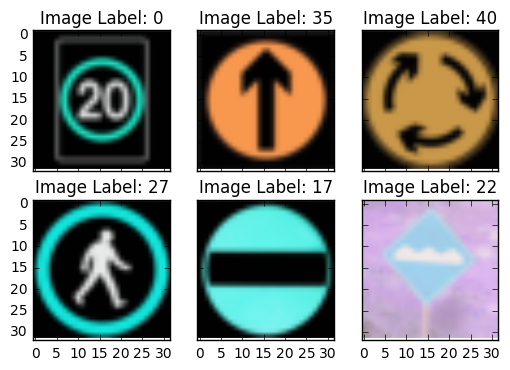

In [44]:
#Visualize the New Test Dataset:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, sharex='col', sharey='row')

ax1.imshow(new_test_dataset[0,:,:,:])
ax1.set_title("Image Label: 0")

ax2.imshow(new_test_dataset[1,:,:,:])
ax2.set_title("Image Label: 35")

ax3.imshow(new_test_dataset[2,:,:,:])
ax3.set_title("Image Label: 40")

ax4.imshow(new_test_dataset[3,:,:,:])
ax4.set_title("Image Label: 27")

ax5.imshow(new_test_dataset[4,:,:,:])
ax5.set_title("Image Label: 17")

ax6.imshow(new_test_dataset[5,:,:,:])
ax6.set_title("Image Label: 22")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** <br>
These images are directly downloaded from the web. At first, there is a chance, the model could mistake these images, because the model was trained on a specific traffic signs related to Europe region i.e Germany. Also noise and low-quality of image 6, there is a chance that it could be mistaken for no-entry sign  or something else, instead of bumpy road.

In [45]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [46]:
# Prediction:
new_test_prediction = tf.nn.softmax(logits)

In [47]:
# Testing
# Launch the graph

predicted_new_test_label = np.zeros((6,43), dtype=np.float32)

with tf.Session() as sess:
    #saver.restore(sess, '/home/tony/Documents/self_driving_car/project2/lenet')
    saver.restore(sess, '/home/tony/Documents/self_driving_car/project2/alexnet')
    
    for i in range(6):
        test = grey_new_test_dataset[i,:,:,:]
        test = np.reshape(test, (1,32,32,1))
        norm_test = normalize_data(test)
        predicted_label = sess.run(new_test_prediction, feed_dict={tf_train_dataset: norm_test, keep_prob: 1.0}) 
        predicted_label  = np.array(predicted_label)
        predicted_new_test_label[i,:] = predicted_label
        test_label = np.argmax(predicted_label)
        print('Image ' + str(i+1) + ' the expected label is: ' + str(new_test_labels[i]))
        print('Image ' + str(i+1) + ' the predicted label is: ' + str(test_label))
        print('')

Image 1 the expected label is: 0
Image 1 the predicted label is: 0

Image 2 the expected label is: 35
Image 2 the predicted label is: 35

Image 3 the expected label is: 40
Image 3 the predicted label is: 36

Image 4 the expected label is: 27
Image 4 the predicted label is: 40

Image 5 the expected label is: 17
Image 5 the predicted label is: 17

Image 6 the expected label is: 22
Image 6 the predicted label is: 13



### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

My model was able to achieve 90.2% on the test dataset provided, but it was able to get three labels correctly out of six on the captured pictures. This makes it only having an accuracy of 50% in the new collected dataset.<br>
As seen that with roundabout symbol and pedestrain symbol the model got easily confused.<br>
Also the bumpy road sign got mis-classified as yield, maybe due to the low quality of image, it could looked more like a yield sign to the model.

In [48]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

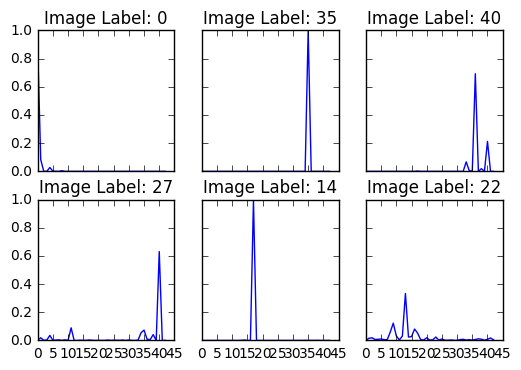

In [49]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, sharex='col', sharey='row')

ax1.plot(predicted_new_test_label[0,:])
ax1.set_title("Image Label: 0")

ax2.plot(predicted_new_test_label[1,:])
ax2.set_title("Image Label: 35")

ax3.plot(predicted_new_test_label[2,:])
ax3.set_title("Image Label: 40")

ax4.plot(predicted_new_test_label[3,:])
ax4.set_title("Image Label: 27")

ax5.plot(predicted_new_test_label[4,:])
ax5.set_title("Image Label: 14")

ax6.plot(predicted_new_test_label[5,:])
ax6.set_title("Image Label: 22")

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** <br>
For Test Image 1, the model correctly predicts the sign. <br>
For Test Image 2, the model correctly predicts the sign. <br>
For Test Image 3, the model does not correctly predicts the sign, but the label does appear in top-3. <br>
For Test Image 4, the model does not correctly predicts the sign, and also the correct prediciton does not appear in top-3. <br>
For Test Image 5, the model correctly predicts the sign. <br>
For Test Image 6, the model does not correctly predicts the sign, and also the correct prediciton appear in top-3. <br>

Below I wrote a program to scan through the softmax output for each image predicition, to check whether the correct prediction appears in top-3.

In [51]:
for i in range(6):
    a = predicted_new_test_label[i,:]
    
    with tf.Session() as sess:
        top_3 = sess.run(tf.nn.top_k(tf.constant(a), k=3))
    
    top_3 = np.array(top_3)
    top_3 = top_3[1]
    
    if new_test_labels[i] in top_3:
        print('For Test Image, ' + str(i+1) + ' the label does appear in top-3') 
    else:
        print('For Test Image, ' + str(i+1) + ' the label does not appear in top-3') 


For Test Image, 1 the label does appear in top-3
For Test Image, 2 the label does appear in top-3
For Test Image, 3 the label does appear in top-3
For Test Image, 4 the label does not appear in top-3
For Test Image, 5 the label does appear in top-3
For Test Image, 6 the label does not appear in top-3


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.